# Lab Session #3
## Computational Neurophysiology [E010620A]
### Dept of Electronics and Informatics (VUB) and Dept of Information Technology (UGent)
Jorne Laton, Lloyd Plumart, Talis Vertriest, Jeroen Van Schependom, Sarah Verhulst

<font color=blue>Student names and IDs: Robbe De Beck [01902805], Robbe De Muynck [01908861]</font> 
<br>
<font color=blue>Academic Year:</font> 2022-2023

<a id="top"></a> 

# Basic Analysis of Spike Train Data

This exercise is adapted from the examples provided in the textbook "Case Studies in Neural Data Analysis", by Mark Kramer and Uri Eden (2016, MIT Press) and the 2020 eLife-LABs publication by Emily Schlafly, Anthea Cheung, Samantha Michalka, Paul Lipton, Caroline Moore-Kochlacs, Jason Bohland, Uri Eden, Mark Kramer. The outline of this exercise follows the theory presented in chapter 7 of "Neuronal Dynamics" by Gerstner, Kistler, Naud, Paninski (2014, Cambridge University Press). It uses two different datasets to introduce and develop some the concepts.

## Aim<a id="introduction"></a>

Typically, the first step in any data analysis involves visualizing and using simple descriptive statistics to characterize pertinent features of the data. For time series data that take on a continuous value at each time point, like the field potentials analyzed in earlier notebooks, we typically start by simply plotting each data value as a function of time. For spike train data, things can become a bit more complicated. One reason for this is that there are multiple equivalent ways to describe the same spike train data. The data could be stored as a sequence of spike times; as a sequence of waiting times between spikes (interspike intervals); or as a discrete time series indicating the number of spikes in discrete time bins. Knowing how to manipulate and visualize spike train data using all these different representations is the first step understanding the structure of the data and is the primary goal of this notebook.

### Case Study 1: Retina Neuron<a id="CS1"></a>

Neurons in the retina typically respond to patterns of light displayed over small sections of the visual field. However, when retinal neurons are grown in culture and held under constant light and environmental conditions, they will still spontaneously fire action potentials. In a fully functioning retina, this spontaneous activity is sometimes described as background firing activity, which is modulated as a function of visual stimuli. It is useful to understand the properties of this background activity in order to determine in future experiments how these firing properties are affected by specific stimuli.

#### Data

A researcher is examining the background firing properties of one of these neurons. He records the spiking activity in one of two states, with the room lights off (low ambient light levels) or with the room lights on (high ambient light levels) and would like to determine whether there is a difference in background firing between these two conditions, and whether one environment is more conducive to future experimental analyses. He records the spiking activity for 30 seconds in each condition.

<div class="question">

**Data:** Spontaneous spiking activity from a retinal neuron in culture, exposed to low-light and high-light environments.

**Goal:** Visualize spike trains, compute and interpret descriptive statistics.

**Tools:** Raster plots, interspike interval histograms, firing rate, autocorrelograms.
    
</div>

#### Before you start
To prepare your environment for this exercise, you'll have to install the nitime package
e.g. type `pip install nitime` in the command line after opening conda or your conda environment

In [1]:
# Prepare the standard modules and load in the data 
from pylab import *
import scipy.io as sio
import warnings
%matplotlib inline
rcParams['figure.figsize']=(12,3)  # Change the default figure size
import matplotlib.pyplot as plt

# and notebook specific modules
from scipy.stats import gamma      # Import the gamma object from the SciPy stats toolbox
warnings.simplefilter(action='ignore', category=FutureWarning)
data = sio.loadmat('matfiles/08_spikes-1.mat')  # Load the spike train data
print(data.keys())

#You should find two variables in the `data` dictionary:
#`SpikesLow`: spike times over 30 s in the low ambient light condition,
#`SpikesHigh`: spike times over 30 s in the high ambient light condition.
#We take these two variables from `data` so we can work with them directly.
spikes_low = data['SpikesLow'][0]
spikes_high = data['SpikesHigh'][0]
#Each variable is a single (1-D) vector that gives a set of increasing spike times for the associated condition.
#Each row holds a single spike time.
#The two vectors are of different sizes (SpikesLow.shape) because the neuron fired a different number of spikes in each condition.

dict_keys(['__header__', '__version__', '__globals__', 'SpikesLow', 'SpikesHigh'])


#### Q1: Compute the firing rate (in Hz) of the neuron in the low- and high-light condition <a id="Q1"></a>
Firing rate ($f$) is mathematically defined as

$$
  f = \frac{n}{T},
  \tag{1}
$$

where $n$ is the number of spikes over the time interval $T$.

* [Fill in answer here](#A1)

#### Q2: Visualise the spike train data <a id="Q2"></a>

* Q2.1: Plot the spike data and identify which variables are plotted on the x- and y-axis.

* Q2.2: The standard way of plotting does not yield dot-raster plots (spikes over time), you can generate such a plot by using the `ones_like()` function. This function produces an array of 1s (ones) that has the same dimensions as the input. When plotting your spikes, use the `'.'` marker and remove the $y$-axis tick marks since they don't carry any real information, in this case `yticks([])`. Compare the low and high-light spike traces in the same figure (and label them), you can do so by multiplying the `ones_like()` function by two to yield separate traces. Compare the traces within 5 s intervals, as well as across the 30s, can you identify marked visual differences between the low and high-light conditions?  

* [Fill in answer here](#A2)    

#### Q3: Spike Counts <a id="Q3"></a>

A common approach analyzing spiking data is to discretize time into bins of fixed width and count the number of events(spikes) in each time bin. The length of the time window is set by the experimenter and depends on the type of neuron and stimulus. Bin sizes are often chosen such that multiple spikes occur in a single bin to yield a meaningfull analysis of the spike train and its variability across time bins. To build statistical models of spike trains, the time bins are taken sufficiently small, say, 1 ms for a typical spike train, such that the resulting binning process (also called increments) is just a sequence of zeros and ones. In this case, the probability that more than one spike occurs in each bin is zero or negligibly small (and similar to actual spiking statistics with refractoriness). Each tiny time bin then contains a spike (assign that bin value 1) or does not (assign that bin value 0). In our case, we use multiple bin sizes to characterize the variability of the spiking data and to examine temporal dependencies between spikes.

* Q3.1: Start by binning the spike train data of low and high-light conditions into time bins of 40 ms. To do so, use the functions `np.histogram()` and `np.arange()`. How many bins have 4 spikes in them, and how many bins have no spikes in them (for both conditions)?

* Q3.2: A question that often arises is how variable the binned counts are. To illustrate this variability, let’s consider two scenarios. In the first, consider a neuron that fires perfectly regularly, like a metronome. In this case, we expect the number of spikes in each time bin to be nearly identical. On the other hand, consider the scenario of a neuron that fires in irregular bursts. In this case, we expect much more variability in the number of spikes in each time bin, depending on whether a time bin contained a burst of spikes or a quiet period. To characterize this variability, a standard measure to compute is the sample ***Fano factor (FF)***. It’s easy to calculate the Fano factor: the sample variance of the binned counts (increments) divided by the sample mean of the binned counts (increments). Use the built in python methods`.mean()` and `.var()` to calculate the FF.

* [Fill in answer here](#A3) 

#### Q4: Fano Factors <a id="Q4"></a>

To understand what the resulting FF means, we can compare the variability of the increments of a spike train (i.e. the FF) to the variability of a Poisson process. When considering spiking activity as a Poisson Process, it is assumed that each spike occurrence is independent of every other spike occurrence. Poisson processes are not necessarily accurate models for spike train data as our biological knowledge reveals that the occurrence of a spike does depend on the occurrence of previous spikes (e.g., because of the refractory period of a neuron, we do not expect a spike to occur immediately after another spike). However, because of the mathematical properties of the Poisson probability distribution, its theoretical variance and mean are equal, yielding a FF of 1, and a good model compare our results to. If the **FF is well below 1** for a particular set of increments, this suggests that the spiking is more regular than a Poisson process for the time scale at which the increments were binned. In this case, spiking activity in the past is influencing the neuron to spike in a more predictable manner in subsequent bins. If the **FF is well above 1**, this suggests that the spiking is more variable than a Poisson process for the time scale at which the increments were binned.

* Q4.1: How do you interpret the FFs you obtained for the low and high-light conditions?

Next, we'd like to get an idea of how far above or below the value of 1 the calculated FF has to be before we can be confident that there is a statistically significant difference in the variability from a Poisson process. After all, even if we had spiking from a true Poisson process, from one experiment to the next we would expect to find different values for the increments, and FF values that fluctuate slightly above and below 1. It can be shown theoretically that the distribution of FFs that we might compute from a Poisson process follows a gamma distribution with shape parameter $(N - 1)/2$ and scale parameter
$2/(N - 1)$, where $N$ is the number of time bins used in the FF calculation [<a href="https://doi.org/10.1016/j.jneumeth.2010.04.012" rel="external">Eden & Kramer, 2010</a>]. 

* Q4.2: Use the `gamma.pdf()` function from scipy to generate a the probability density function that goes with the Poisson process and calculate the confidence interval bounds (2.5 and 97.5% points) outside which FFs are significantly different from the FF belonging to a Poisson process to answer the question as to whether your low- or high-light spiking rates are significantly different from a Poisson process (Motivate your answer).Use the `gamma.ppf()` function from scipy.

* Q4.3: How do the results for the Fano factor change in each condition with different choices for the bin size of the increment process (e.g., 25 ms, 100 ms, 400 ms)?

* [Fill in answer here](#A4) 

#### Q5: Interspike interval distributions <a id="Q5"></a>

A common method to study neural variability given a certain stationnary input, is by means of the interspike-interval (ISI) distributions. This method can quantify bursts of spikes that cluster near each other in time, or identify periods that contain less spikes. If you zoom in on your dot-raster plots (e.g. in a 0.4s window), you can observe qualitative differences in the spiking structure between the low- and high-light conditions. 

Q5.1: Use the `np.diff()` function to study the ISI for each condition, and afterwards use a histogram to visualize and compare the ISIs in 20 ms and 2ms bins. Describe the features of the two histograms. What features of the ISI distributions are similar for the two conditions? What features are most strikingly different? Quantitatively describe how the neurons spike in response to the two conditions (and on which time scales).

* [Fill in answer here](#A5)

#### Q6: Autocorrelation functions (ACF)  <a id="Q6"></a>

For a stationary input scenario where a neuron fires a first spike at time t, the ISI distribution describes the probability that the next spike occurs at t+s. Instead, the autocorrelation function $$C_{xx}[s]$$ focuses on the probability of finding **another** spike at time t+s, independent of whether this is the next spike of the neuron or not. Mathematically, the formula for the sample autocorrelation at a lag $s$ is
$$
  C_{xx}[s] = \dfrac{
  \sum_{n=1}^{N - s}
  (x_n - \bar{x})(x_{n+s} - \bar{x})
  }
  {
  \sum_{n=1}^{N}(x_n - \bar{x})^2
  }
$$
where $x_n$ is the $n^{th}$ data point, and $\bar{x}$ is the sample mean of the data over index $n$.

* Q6.1: When considering the ISI histograms of Q5, we might expect relations between spiking events to extend up to 200 ms. First, compute the full autocorrelation `correlate(,'full')` for the low and high-light condition using increments of 50 ms (50ms binned histogram outputs) for lag 0 and 3 more lags (lag0=0ms-50ms, lag1=50ms-100ms, lag2=100ms-150ms, lag3=150ms-200ms). What is the correlation coefficient at lag 0 and did you expect this value? How can we interpret the values of the correlation values at the other considered lags?

* Q6.2: To assess whether the correlation coefficients are significant, you can approximate the confidence interval based on a standard normal distribution with standard deviation $$1/\sqrt(N)$$, for which any correlation value exceeding $$\pm 2/\sqrt(N)$$ is unlikely to be generated by chance. Calculate the significance boundary and compare your found correlation factors to them to answer whether they reflect significantly correlated relationships. Plot the autocorrelation values as a function of lag, and also plot two lines that indicate the two confidence boundaries.  

* Q6.3: To get a more fine-grained view on the autocorrelation function, generate a new histogram with 1-ms bins, and calculate the autocorrelation functions for lags corresponding to 100-ms (100 lags). Plot the autocorrelation values as in Q6.2. For which time-lags do the values in the low and high-light condition exceed the confidence boundaries, and what does this mean for the spiking process? 

* Q6.4: To answer the question as to whether the differences in the autocorrelations between these two conditions are real, you can compute the difference in the autocorrelation functions between the low- and high-light conditions at every lag (for the histogram with 1ms bins). If we assume that the firing in each condition is independent, the significance bounds for this difference can be computed by the square root of the sum of the variances of the autocorrelation from each condition. The standard deviation of the autocorrelation for the low-light condition is $1/\sqrt{N_1}$, so the variance of the auto- correlation for the low-light condition is $1/N_1$. For the high-light condition, the variance of the autocorrelation is $1/N_2$. Plot the differenced autocorrelations and the significance bounds, to answer whether there are significantly different autocorrelations in the two conditions.

* [Fill in answer here](#A6)

### Case Study 2: The subthalamic nucleus <a id="CS2"></a>
#### Q7: Peri-stimulus-time histograms (PSTH)  <a id="Q7"></a>

Before we delve deeper into the statistical models underlying neuronal spiking, we'll introduce one more common experimental neuroscience technique that is based on repeating the stimulation sequence several times. The neuronal responses are reported in a peri-stimulus time histogram (PSTH) with bin width $\Delta t$ (in the order of $ms$) and $t$ measured with respect to the start of the stimulation sequence. We'll apply this concept on an experiment in which 
a clinical neurosurgeon is analyzing spiking data from patients with Parkinson’s disease during surgery to implant DBS electrodes. To assess whether the electrode is localized properly in the STN (subthalamic nucleus), and to study STN activity during the planning and execution of a movement. Each patient as asked multiple times to perform a simple hand movement task during the electrode implantation procedure, while the resulting neural activity is recorded.

The data of the hand movement task consists of single unit spiking activity from one STN neuron recorded over 50 trials. In each trial, a patient held a joystick and watched cues appear on a screen. The first cue indicated whether the patient should move the joystick to the left or right. The second cue, the GO cue, indicated the time to start moving the joystick. The dataset contains 2s of activity for each trial, 1s before the GO cue and 1s after. We label the period before the GO cue as the planning period, and the period after the GO cue as the movement period.

**GOAL:** Some STN neurons in patients with Parkinson’s disease shows rhythmic properties in the beta frequency range, 11–30 Hz (<a href="https://doi.org/10.1001/archneurpsyc.1938.02270010106010" rel="external">[Jasper & Andrews, 1938]</a>, <a href="https://doi.org/10.1016/j.neuroimage.2013.05.084" rel="external">[Brittain & Brown, 2014]</a>), hence the neurosurgeon hypothesizes that information related to the movement task, such as a) the planning versus the movement period and b) whether the movement is to the left or right, will influence this rhythmic spiking activity. Your goal is to characterize the spiking properties, identify whether rhythmic activity is present and statistically significant, and how such activity is influenced by the task variables.

In [33]:
# Load in the modules for this notebook and the data itself
from nitime.algorithms import multi_taper_psd
from nitime.utils import dpss_windows
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson
import statsmodels.formula.api as smf
from pandas import DataFrame as df
from pandas import concat
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import chi2, norm
rcParams['figure.figsize']=(12,3)               # Change the default figure size

data2 = sio.loadmat('matfiles/10_spikes-1.mat') # Load the spike train data.
t = data2['t'][0]                         # Extract the t variable.
direction = data2['direction'].flatten()  # Extract the direction variable.
train = data2['train']                    # Extract the train variable

The dataset has three variables:

  * `direction`: A 50&times;1 vector of indicators for the movement direction for each of 50 trials. A value of 0 indicates movement to the left, and a value of 1 indicates movement to the right.
  
  
  * `t`: A 1&times;2000 vector of time stamps in milliseconds indicating the time into the trial. Time 0 indicates the GO cue.
  
  
  * `train`: A 50&times;2000 matrix of spike values (1 if spike, 0 if not) for each ms and for each trial. The rows of the matrix correspond to trials, while the columns correspond to time(ms).
  
* Q7.1: Start by visualizing your dataset in a dot-raster plot. You can use the `plt.imshow()` function to visualize Matrixes with 0's and 1's. Group the left and right trial responses, do you notice qualitative differences between them, and is rythmic spiking apparent? 

* Q7.2: PSTHs are useful for visualizing the relation between spike rates per bin. To compute the PSTH, the spikes times are partitioned into bins, and the number of spikes that occur within each bin are added across trials, and then divided by the number of trials and the length of the bin. In other words, this is a normal histogram but now averaged over all trials. Scale your y-axis to spike rate per second per bin. Use a 1ms, and later 10ms bin-size and functions `np.where()`, `np.histogram()`, and the `plt.bar()` plotting function to evaluate whether spiking is different in the planning and movement periods.  What effect does the choice of bin-size have on your results interpretation, and what is a good bin size in your opinion?

* Q7.3: Next, quantify the average firing rate in planning and movement periods by averaging the spiking data across trials and time in each period. Are these consistent with your visual inspections? Afterwards, break down the rates into those belonging to the left and right movement tasks, are there differences?

* Q7.4: Using a boxplot, you can also visualise the trial-to-trial variability distribution in each of the 4 conditions (plan-left, movement-left, plan-right, movement-right). Use 1s time-windows for this analysis and use the `plt.boxplot()` function for this analysis. What is the S.I. unit corresponding to the variables in your boxplot, and which conditions yield significantly different results (based on the graphical boxplot results)

* [Fill in answer here](#A7)

#### Q8: Rhythmic structure  <a id="Q8"></a>

Boxplots were helpful to visualise the long-term spiking structure over periods of about 1 s, but do not provided much information about short-term rhythmic structure. At the same time, it was our goal to identify whether there was rhythmic structure in the spiking activitiy. 

* Q8.1: To this end, you can first compute the ISI histograms of the planning and movement case. Afterwards, average the ISI histograms accross trials to compare whether there are visual differences between the ISI's of the planning and movement case.

* Q8.2: Another function to visualize history-dependent spike properties, is the sample **autocorrelation function** (ACF). Recall that the ACF shows the correlation between a signal at two points in time separated by a fixed lag. Different lags are evaluated. For these spike train data, let’s use the increments (i.e., the number of spikes in each time bin) as the signal, compute the ACF for each trial, and average the results over all the trials.

* Q8.3: So far, we have focused on statistical characterizations of spike trains in the time domain. Another approach to visualizing and describing structure in point processes focuses on estimating rhythmic (or harmonic) features of the data in the frequency domain. The autocorrelation function is closely linked to the power spectrum of a neuronal spike train, in fact, the power spectrum of a spike train equals the Fourier transform of its autocorrelation function (Wiener-Khinchin theorem - see lecture). Look up and use the `multi_taper_psd()` function (Nitime package) to compute the power spectral density for each trial (planning and movement periods separately) and average the results across trials. 

The planning and movement periods for each trial are 1 s in duration, so we can achieve a 4 Hz frequency resolution by setting the time-bandwidth product to 4. This allows us to use seven tapers, each providing independent and informative estimates. Tapering is a common method to avoid artifacts from discontinuities created by non-periodic data near the window boundaries (periodicity is a basic assumption in FFT). More info on multi-tapers: https://en.wikipedia.org/wiki/Multitaper
You can also calculate the spectrum by hand. The main reason for this is that we are working with 
point process data and most packages assume that a signal is continuous. 
Define a function mt_specpb to calculate the spectrum manually.  
In this case, because the mean firing rate is so low, the difference is trivial. 
The multi_taper_psd() function from the Nitime package thus produces nearly the same result as mt_specpb, 
though it must be rescaled to see this. 
which line of the function shows that it treats the data as data points instead of continuous data?

* Q8.4: While computing the spectrums, we inherently assumed that the data of the planning period are stationary. In other words, that the mean and autocovariance structure do not change in time. We then concluded a sudden change between the planning and the movement periods and again that the data are stationary again during the movement period. To test whether this is a reasonable assumption, you can compute a spectrogram, using your `mt_specpb` function and`plt.contourf`. 
Use a moving window of 500 ms duration and a step size of 50 ms. Was the stationarity assumption reasonable for this dataset?


* [Fill in answer here](#A8)

#### A1: Compute the firing rate (in Hz) of the neuron in the high- and low-light condition <a id="A1"></a>
* [Go back to Q1](#Q1)

In [2]:
# Use the following variables:
#f_low
#f_high

#####################
##   Q1 solution   ##
#####################
# print(spikes_high.shape)
# print(spikes_low.shape)
f_low = len(spikes_low)/30 # Hz
f_high = len(spikes_high)/30 # Hz

print('f_low = ', f_low, 'Hz')
print('f_high = ', f_high, "Hz")

f_low =  25.0 Hz
f_high =  32.3 Hz


<div class="alert alert-success">
<span style="color:black">

**A1 conclusion** 
    
<!-- \begin{tcolorbox}[colback=green!5] -->
    
A higher ambient light condition results in a higher firing rate.

<!-- \end{tcolorbox} -->
    
</span>

#### A2: Visualise the spike train data <a id="A2"></a>
* [Go back to Q2](#Q2)   

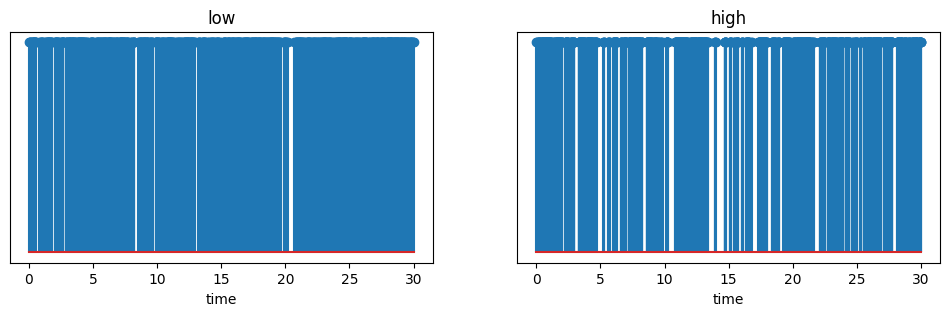

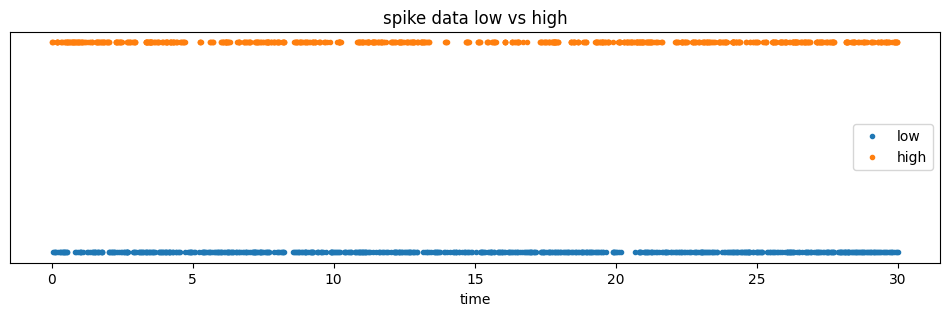

In [3]:
# Your start data is spikes_low and spikes_high

#######################
##   Q2.1 solution   ##
#######################
# time = np.linspace(0,30,len())
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.stem(spikes_low, np.ones(len(spikes_low)))
ax2.stem(spikes_high, np.ones(len(spikes_high)))
ax1.set_xlabel('time')
ax2.set_xlabel('time')
ax1.set_title('low')
ax2.set_title('high')
ax1.set_yticks([])
ax2.set_yticks([])

plt.show()

#######################
##   Q2.2 solution   ##
#######################

fig, ax1 = plt.subplots(1,1)
ax1.plot(spikes_low, ones_like(spikes_low),'.',label='low')
ax1.plot(spikes_high, ones_like(spikes_high)*2,'.',label='high')
ax1.set_xlabel('time')
ax1.set_xlabel('time')
ax1.set_yticks([])
ax1.set_yticks([])
ax1.set_title('spike data low vs high')
plt.legend()
plt.show()

<div class="alert alert-success">
<span style="color:black">

**A2 conclusion** 
    
\begin{tcolorbox}[colback=green!5]
    
Your answer here

\end{tcolorbox}
    
</span>

#### A3: Spike Rates  <a id="A3"></a>
* [Go back to Q3](#Q3)   


bins with 4 spikes: low 1; high 52
bins with 0 spikes: low 231; high 327



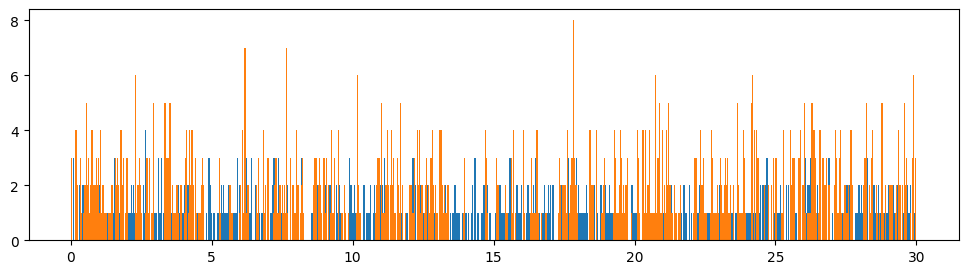

In [27]:
# Hint: if you use np.arange (as suggested), make sure that also your end time is included in the range.
# Hint: you can also use np.linspace, make sure that you want the number of time_edges of the bins, not the number of bins.
# Hint: you can use plt.hist() to plot but dont use plt.hist() to calculate the histogram values because it returns floating numbers, which will give troubles in your future calculations.

# Use the following variables:
#increments_low_50
#increments_high_50
#time_bin_edges
#bins_low_4spikes
#bins_low_0spikes
#bins_high_4spikes
#bins_high_0spikes

######################
##  Q3.1 solution   ##
######################
time_bin_edges = np.arange(0, 30.040, 0.040)
plt.hist(spikes_low, bins=time_bin_edges)
hist_low, _ = np.histogram(spikes_low, bins=time_bin_edges)
plt.hist(spikes_high, bins=time_bin_edges)
hist_high, _ = np.histogram(spikes_high, bins=time_bin_edges)

bins_low_4spikes = (hist_low == 4)*1
bins_low_0spikes = (hist_low == 0)*1

bins_high_4spikes = (hist_high == 4)*1
bins_high_0spikes = (hist_high == 0)*1

print(f"""
bins with 4 spikes: low {np.sum(bins_low_4spikes)}; high {np.sum(bins_high_4spikes)}
bins with 0 spikes: low {np.sum(bins_low_0spikes)}; high {np.sum(bins_high_0spikes)}
""")

In [5]:
# Use the following variables:
#FF_low_50
#FF_high_50

######################
##  Q3.2 solution   ##
######################

FF_low_40 = var(hist_low)/mean(hist_low)
FF_high_40 = var(hist_high)/mean(hist_high)

print(f"""
FF_low_40: {FF_low_40:.3f}
FF_high_40: {FF_high_40:.3f}
""")


FF_low_40: 0.704
FF_high_40: 1.731



<div class="alert alert-success">
<span style="color:black">

**A3 conclusion** 

\begin{tcolorbox}[colback=green!5]
    
Your answer here

\end{tcolorbox}
    
</span>

#### A4: Fano Factor  <a id="A4"></a>
* [Go back to Q4](#Q4)   

In [9]:
from scipy.stats import gamma   # Import the gamma object from the SciPy stats toolbox

# Use the following variables:
#ppf_low_50 (an array with 2 values: the lower and upper percentile)
#ppf_high_50
#ppf_low_25
#ppf_high_25
#ppf_low_100
#ppf_high_100
#ppf_low_500
#ppf_high_500

#######################
##   Q4.1 solution   ##
#######################

#see anwer bellow

#######################
##   Q4.2 solution   ##
#######################

def gamma_function(nr_bins,increments,high_low, binsize):
    a = np.linspace(1,nr_bins,nr_bins)
    poisson = gamma.pdf(binsize, a)
    return ppf, FF

ppf, FF = gamma_function(20,_,(2.5,97.5), 4)
#######################
##   Q4.3 solution   ##
#######################



[1.83156389e-02 7.32625556e-02 1.46525111e-01 1.95366815e-01
 1.95366815e-01 1.56293452e-01 1.04195635e-01 5.95403626e-02
 2.97701813e-02 1.32311917e-02 5.29247668e-03 1.92453697e-03
 6.41512324e-04 1.97388408e-04 5.63966879e-05 1.50391168e-05
 3.75977919e-06 8.84653927e-07 1.96589762e-07 4.13873182e-08]


TypeError: cannot unpack non-iterable NoneType object

<div class="alert alert-success">
<span style="color:black">

**A4.1 answer** 
    
\begin{tcolorbox}[colback=green!5]
    
Your answer here

\end{tcolorbox}
    
</span>

<div class="alert alert-success">
<span style="color:black">

**A4 conclusion** 
    
\begin{tcolorbox}[colback=green!5]
    
Your answer here

\end{tcolorbox}
    
</span>

#### A5: Interspike Intervals  <a id="A5"></a>
* [Go back to Q5](#Q5)   

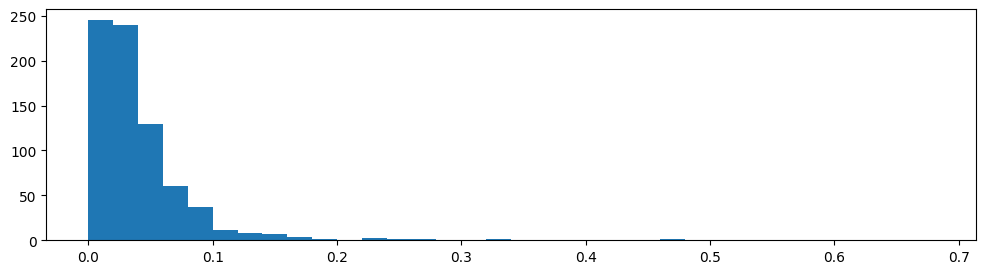

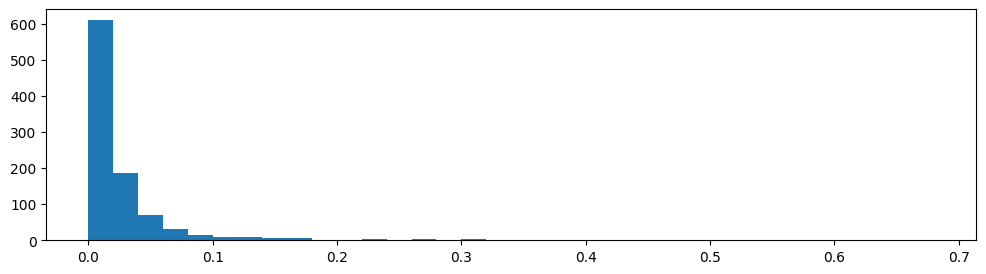

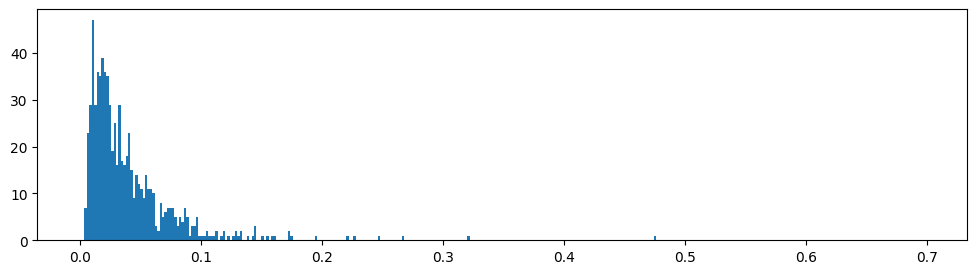

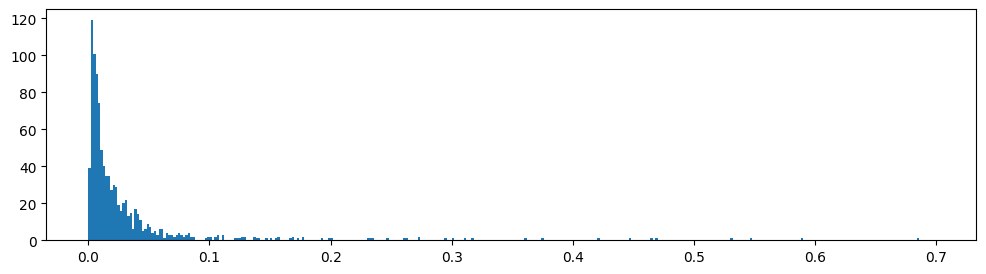

In [31]:
# Use the following variables: 

#ISI_low
#ISI_high
#ISI_hist_low_10
#ISI_hist_high_10
#ISI_hist_low_1
#ISI_hist_high_1

#######################
##   Q5.1 solution   ##
#######################

ISI_low = np.diff(spikes_low)
ISI_high = np.diff(spikes_high)
# print(max(ISI_high),max(ISI_low))
time_bin_edges = np.arange(0, 0.7, 0.020)
ISI_hist_low_20, _ = np.histogram(ISI_low, time_bin_edges)
plt.hist(ISI_low, time_bin_edges)
plt.show()

ISI_hist_high_20, _ = np.histogram(ISI_high, time_bin_edges)
plt.hist(ISI_high, time_bin_edges)
plt.show()

time_bin_edges = np.arange(0, 0.7, 0.002)
ISI_hist_low_2, _ = np.histogram(ISI_low, time_bin_edges)
plt.hist(ISI_low, time_bin_edges)
plt.show()

ISI_hist_high_2, _ = histogram(ISI_high, time_bin_edges)
plt.hist(ISI_high, time_bin_edges)
plt.show()


<div class="alert alert-success">
<span style="color:black">

**A5 conclusion** 
    
\begin{tcolorbox}[colback=green!5]
    
Your answer here

\end{tcolorbox}
    
</span>

#### A6: Autocorrelation functions (ACF) <a id="A6"></a>
* [Go back to Q6](#Q6)  

In [ ]:
# Hint: when using the np.correlate(,'full') function, the location of your first lag at lag 0 (t=0) is at index xcorr.size//2, figure out why.

#use the following variables:
#ACF_low_50 
#ACF_high_50 
#ACF_low_1
#ACF_high_1

#######################
##   Q6.1 solution   ##
#######################

def autocorr(x, lags):

    return x_corr[:lags+1] # Return only requested lags


#######################
##   Q6.2 solution   ##
#######################




#######################
##   Q6.3 solution   ##
#######################



#######################
##   Q6.4 solution   ##
#######################



<div class="alert alert-success">
<span style="color:black">

**A6.1 answer** 
    
\begin{tcolorbox}[colback=green!5]
    
Your answer here

\end{tcolorbox}
    
</span>

<div class="alert alert-success">
<span style="color:black">

**A6.2 answer** 
    
\begin{tcolorbox}[colback=green!5]
    
Your answer here

\end{tcolorbox}
    
</span>

<div class="alert alert-success">
<span style="color:black">

**A6.3 answer** 
    
\begin{tcolorbox}[colback=green!5]
    
Your answer here

\end{tcolorbox}
    
</span>

<div class="alert alert-success">
<span style="color:black">

**A6.4 answer** 
    
\begin{tcolorbox}[colback=green!5]
    
Your answer here

\end{tcolorbox}
    
</span>

#### A7: Peri-stimulus-time histogram (PSTH)  <a id="A7"></a>
* [Go back to Q7](#Q7)  

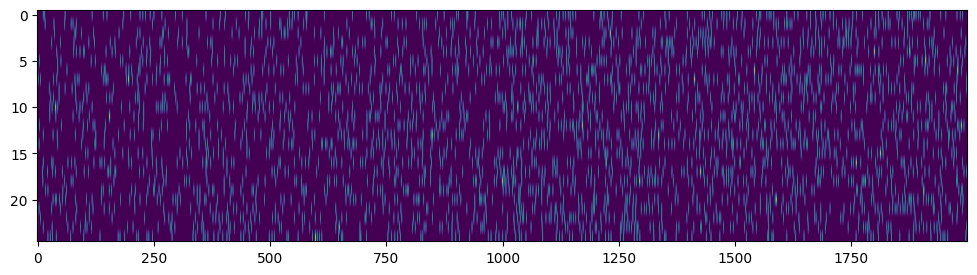

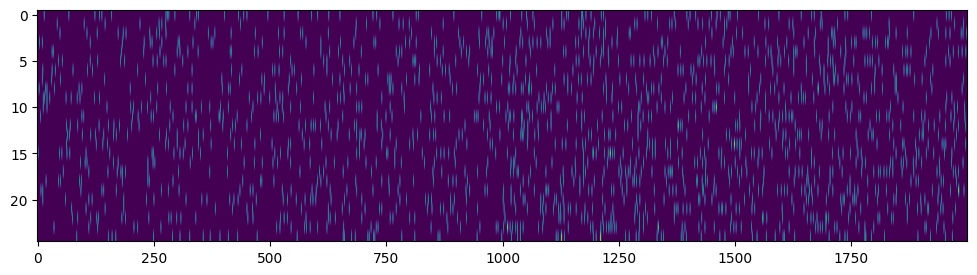

In [56]:
#######################
##   Q7.1 solution   ##
#######################

# The direction vector should contain 0 for a left trial and 1 for a right trial.
# The sum function provides an efficient method to do so: sum(direction) which returns a value of 25. 
# We conclude that half of the 50 trials involve right movement, and half involve left movement.

idx_right = np.where(direction)[0]
idx_left = np.where(direction==0)[0]
train_right = train[idx_right,:]
train_left = train[idx_left,:]

plt.imshow(train_left, aspect='auto')
plt.show()
plt.imshow(train_right, aspect='auto')
plt.show()

#######################
##   Q7.2 solution   ##
#######################



#######################
##   Q7.3 solution   ##
#######################


#######################
##   Q7.4 solution   ##
#######################



<div class="alert alert-success">
<span style="color:black">

**A7.1 conclusion** 
    
\begin{tcolorbox}[colback=green!5]
    
Your answer here

\end{tcolorbox}
    
</span>

<div class="alert alert-success">
<span style="color:black">

**A7.2 conclusion** 
    
\begin{tcolorbox}[colback=green!5]
    
Your answer here

\end{tcolorbox}
    
</span>

<div class="alert alert-success">
<span style="color:black">

**A7.3 conclusion** 
    
\begin{tcolorbox}[colback=green!5]
    
Your answer here

\end{tcolorbox}
    
</span>

<div class="alert alert-success">
<span style="color:black">

**A7.4 conclusion** 
    
\begin{tcolorbox}[colback=green!5]
    
Your answer here

\end{tcolorbox}
    
</span>

#### A8: Rhythmic structure  <a id="A8"></a>
* [Go back to Q8](#Q8)  

In [ ]:
# Q8.1:use the following variables:
#plan_train
#move_train
#plan_average_ISI_hist  ##the average ISI histogram accross all trials for the planning activity, bins of 1ms
#move_average_ISI_hist  ##the average ISI histogram accross all trials for the moving activity, bins of 1 ms

# Q8.2:use the following variables:
#average_ACF_plan
#average_ACF_move

# Note for Q8.2:
# The 'full' correlation function repeats equal values twice, 
# Because going back in time is the same ACF value as going further in time. 
# Start your correlate array halfway of the values returned by np.correlate('full').

# Note for Q8.3:
# Power spectral density (psd)
# Below you find the package input needs.
# nitime.algorithms.spectral.multi_taper_psd(s, Fs=6.283185307179586, NW=None, BW=None, adaptive=False, jackknife=True, low_bias=True, sides='default', NFFT=None)
# Fs is the sampling rate per second, here 1000
# s is sample, so the plan or move train
# NW stands for the time - bandwidth. This gives 2*NW-1 (7)tapers
# to have a better understanding of the multitaper method, you can watch the following video:
# https://www.youtube.com/watch?v=OBwnmiVT9TE

# Try to create the mt_specpb function with the help of:
# https://mark-kramer.github.io/Case-Studies-Python/10.html

# Note for  Q8.4:
# The plt.contour function needs the following input.
# plt.contourf([X, Y,] Z, [levels], **kwargs) #Z is optional

#######################
##   Q8.1 solution   ##
#######################


#######################
##   Q8.2 solution   ##
#######################

def autocorr_train(x, lags=None):

    return corr


def ACFloop(binsize,train,lags=None):

    return average_ACF


#######################
##   Q8.3 solution   ##
#######################


#######################
##   Q8.4 solution   ##
#######################





<div class="alert alert-success">
<span style="color:black">

**A8.1 conclusion** 
    
\begin{tcolorbox}[colback=green!5]
    
Your answer here

\end{tcolorbox}
    
</span>

<div class="alert alert-success">
<span style="color:black">

**A8.2 conclusion** 
    
\begin{tcolorbox}[colback=green!5]
    
Your answer here

\end{tcolorbox}
    
</span>

<div class="alert alert-success">
<span style="color:black">

**A8.3 conclusion** 
    
\begin{tcolorbox}[colback=green!5]
    
Your answer here

\end{tcolorbox}
    
</span>

<div class="alert alert-success">
<span style="color:black">

**A8.4 conclusion** 
    
\begin{tcolorbox}[colback=green!5]
    
Your answer here

\end{tcolorbox}
    
</span>